# Yoga action recognition model

In [73]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [74]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose
 
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
 
mp_drawing = mp.solutions.drawing_utils

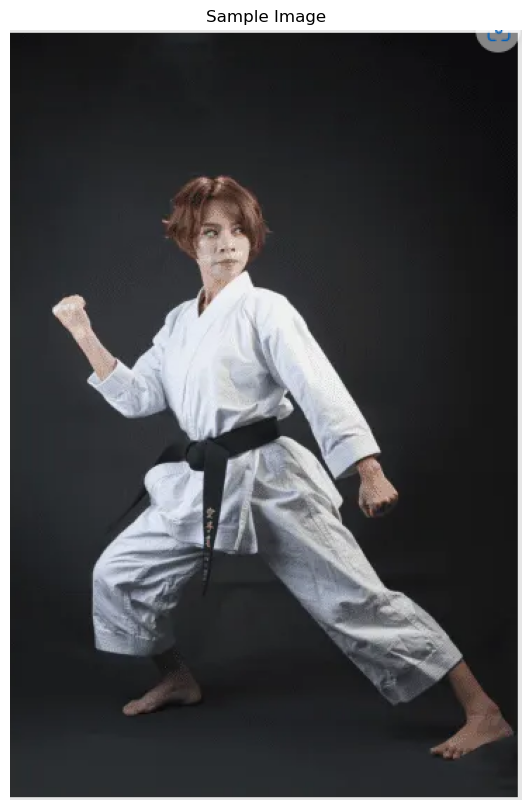

In [12]:
sample_img = cv2.imread('image.png')
 
plt.figure(figsize = [10, 10])
 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [13]:
# Display the found normalized landmarks.

results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

if results.pose_landmarks:
    
    for i in range(2):
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 


NOSE:
x: 0.42569389939308167
y: 0.27912187576293945
z: -0.7612374424934387
visibility: 0.9999998807907104

LEFT_EYE_INNER:
x: 0.4334019124507904
y: 0.26112645864486694
z: -0.7213292121887207
visibility: 0.9999998807907104



In [14]:
# Display the found landmarks after converting them into their original scale.

image_height, image_width, _ = sample_img.shape
 
if results.pose_landmarks:
    
    for i in range(2):        
        print(f'{mp_pose.PoseLandmark(i).name}:') 
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 154.95257937908173
y: 152.95878791809082
z: -277.0904290676117
visibility: 0.9999998807907104

LEFT_EYE_INNER:
x: 157.7582961320877
y: 143.09729933738708
z: -262.56383323669434
visibility: 0.9999998807907104



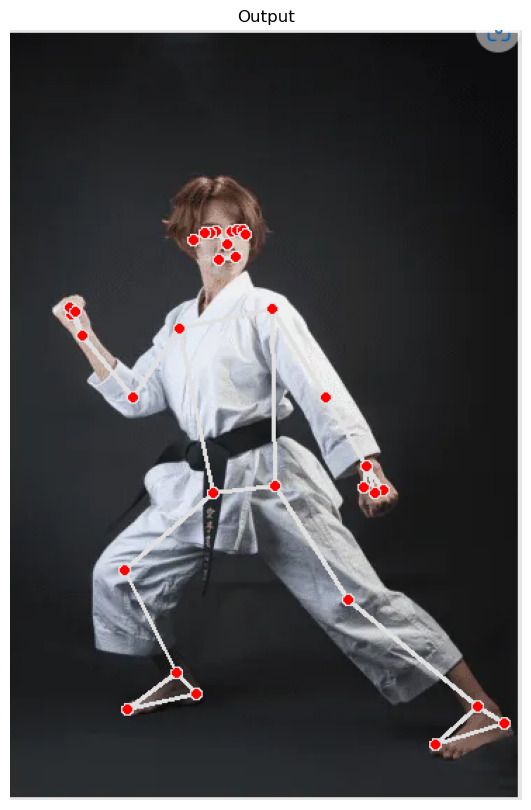

In [15]:
img_copy = sample_img.copy()
 
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    fig = plt.figure(figsize = [10, 10])
    
    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

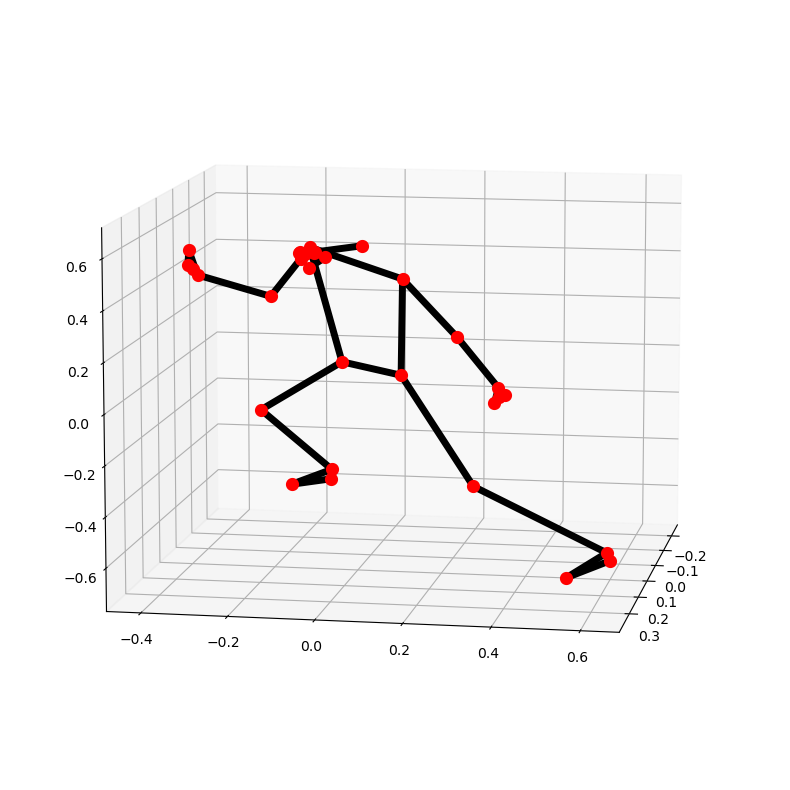

In [20]:
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [77]:
def detectPose(image, pose, display=True):    
    output_image = image.copy()
    
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(imageRGB)
    
    height, width, _ = image.shape
    
    landmarks = []
    
    if results.pose_landmarks:
    
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    if display:
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
      
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    else:        
        return output_image, landmarks

In [24]:
def calculateAngle(landmark1, landmark2, landmark3): 
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
 
    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    if angle  < 0:
 
        angle += 360
    
    return angle

In [78]:
def classifyPose(landmarks, output_image, display=False):
 
    
    label = 'Unknown Pose'
 
    color = (0, 0, 255)
    
    # Calculate the required angles.
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
 
    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
 
    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
 
    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    # Check if it is the warrior II pose or the T pose.
    
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
           
 
    # Check if it is the warrior II pose.
 
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                if left_knee_angle > 90 and left_knee_angle < 190 or right_knee_angle > 90 and right_knee_angle < 190:
                    label = 'Warrior II Pose' 
                        
    
    # Check if it is the T pose.
    
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
 
                label = 'T Pose'
 
    
    # Check if it is the tree pose.
    
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
 
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:
 
            label = 'Tree Pose'
                
    
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        color = (0, 255, 0)  
    
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    if display:    
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:        
        return output_image, label

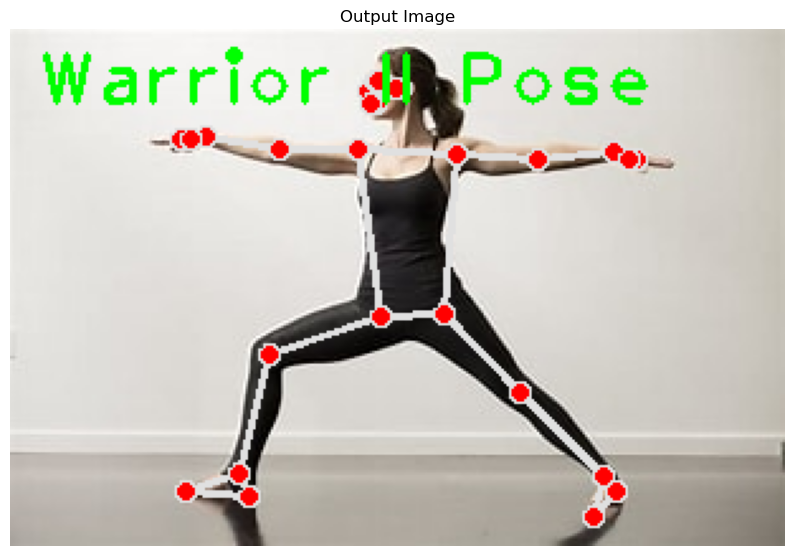

In [82]:
image = cv2.imread('image2.png')
output_image, landmarks = detectPose(image, pose, display=False)
cv2.imwrite('output/img2.png',output_image)        

if landmarks:
    classifyPose(landmarks, output_image, display=True)

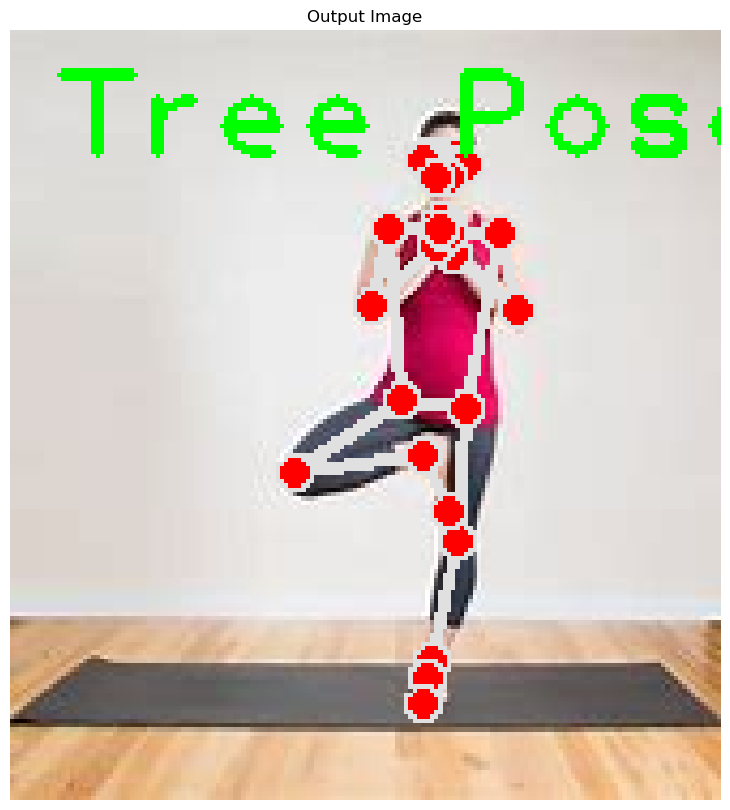

In [81]:
image = cv2.imread('image4.png')
output_image, landmarks = detectPose(image, pose, display=False)
cv2.imwrite('output/img4.png',output_image)        
if landmarks:
    classifyPose(landmarks, output_image, display=True)

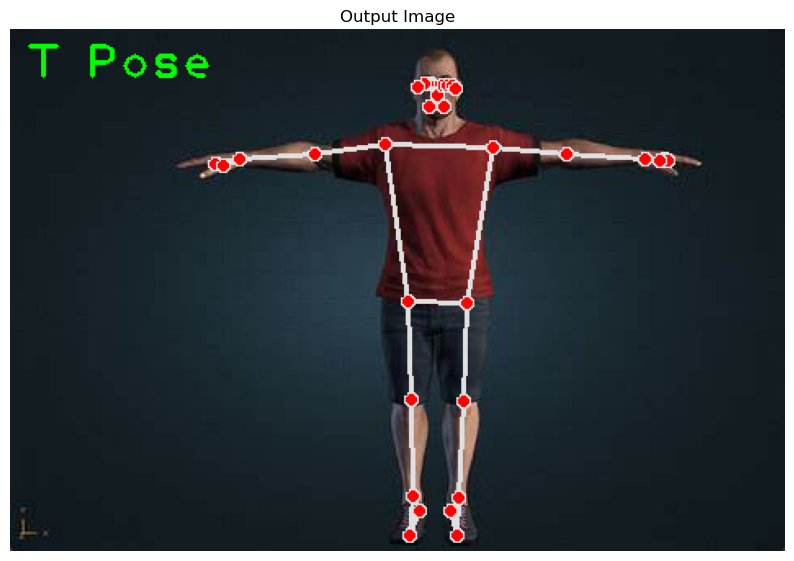

In [83]:
image = cv2.imread('image6.png')
output_image, landmarks = detectPose(image, pose, display=False)
cv2.imwrite('output/img6.png',output_image)        

if landmarks:
    classifyPose(landmarks, output_image, display=True)

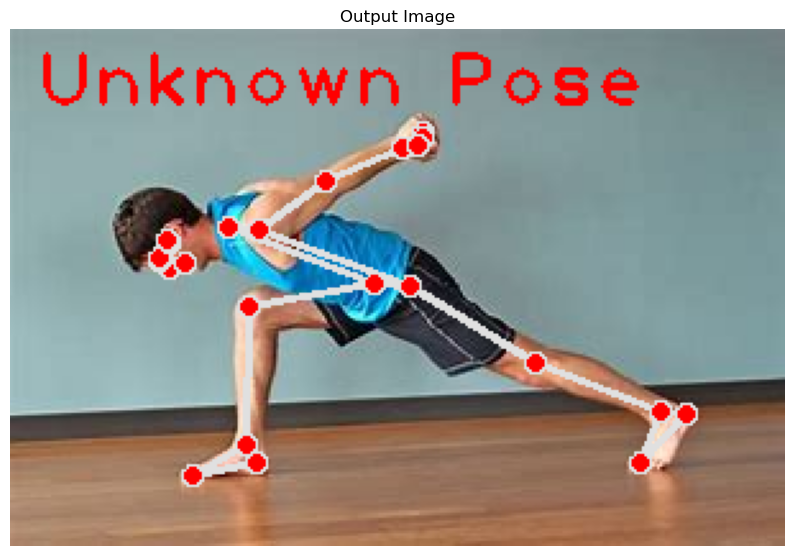

In [84]:
image = cv2.imread('image7.png')
output_image, landmarks = detectPose(image, pose, display=False)
cv2.imwrite('output/img7.png',output_image)        

if landmarks:
    classifyPose(landmarks, output_image, display=True)